<img style="float:left;margin-left: -12px; margin-top: -10px" src="yelp-logo-27.png"  width=50>

# Part 2: Natural Language Processing

In this notebook we will now go through the text data in the reviews and class/business descriptions. By preprocessing this data and using the NLP tools provided to us through <span style="color:blue">*__Spacy__*</span> and <span style="color:blue">__*NLTK*__</span> we will be able to derive some meaning from the text to *hopefully* improve our models.

The steps involved in this are as follows: 

1. word count
2. character count
3. Number of numerics
4. Number of upper case
5. Number of Exclamation Points (!)
7. Count of stop words
8. drop stop words
9. lemmetize our words
10. TF-IDF
11. Class Imbalance and Sentiment Analysis

#### Import needed libraries:

In [31]:
import pandas as pd
import numpy as np
import spacy
import pickle
from Mod_5_functions import (pickle_file,open_pickle,in_nyc,
                             clean_text_column,return_lemma,replace_fixed_words)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm._tqdm_notebook import tqdm_notebook
%matplotlib inline

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

#### Import the pickled DataFrames:

In [2]:
user_reviews_df = open_pickle('Data/filtered_user_data.pkl')

#### 1. word count:

In [3]:
user_reviews_df['word_count'] = user_reviews_df.rev_comp_reviews.apply(lambda x: len(str(x).split(' ')))

#### 2. character count


In [4]:
user_reviews_df['char_count'] = user_reviews_df.rev_comp_reviews.str.len() #this includes the spaces

#### 3. Number of numerics


In [5]:
user_reviews_df['numerics'] = user_reviews_df.rev_comp_reviews.apply(lambda x: len([x for x in x.split() if x.isdigit()]))

#### 4. Number of upper case


In [6]:
user_reviews_df['upper'] = user_reviews_df.rev_comp_reviews.apply(lambda x: len([x for x in x.split() if x.isupper()]))

#### 5. Number of Exclamation Points (!)


In [7]:
user_reviews_df['bangs'] = user_reviews_df.rev_comp_reviews.apply(lambda x: len([x for x in x.split('!')]) - 1 )

#### 6. Count of stop words


In [8]:
stop = stopwords.words('english')

user_reviews_df['stp_wrd_cnt'] = user_reviews_df.rev_comp_reviews.apply(lambda x: 
                                                                        len([x for x in x.split() if x in stop]))

In [9]:
user_reviews_df.head(3)

,comapny_source,company_loc,rev_comp_rating,rev_comp_reviews,rev_comp_url,rev_company_name,userUrl,word_count,char_count,numerics,upper,bangs,stp_wrd_cnt
0,Peloton,"370 Canal St New York, NY 10013",3.0,"Planet Fitness is an affordable, no frills gym...",https://www.yelp.com/biz/planet-fitness-manhat...,Planet Fitness - Manhattan - Canal St - NY,https://www.yelp.com/user_details?userid=exPhu...,219,1189,0,5,0,100
1,Peloton,"90 E 10th St New York, NY 10003",2.0,I purchased a Groupon for a friend and I. When...,https://www.yelp.com/biz/montauk-salt-cave-new...,Montauk Salt Cave,https://www.yelp.com/user_details?userid=exPhu...,791,4417,2,19,4,331
2,Peloton,"1841 Broadway New York, NY 11023",3.0,"I enjoyed my class, but this was one of my lea...",https://www.yelp.com/biz/pure-barre-new-york-c...,Pure Barre - New York Columbus Circle - 60th &...,https://www.yelp.com/user_details?userid=exPhu...,88,480,0,2,0,39


### Data Preprocessing

Next, we need to move into data cleaning. This section will be very important for the remaineder of this project and the models we run. In the next few cells we will:
1. create a function to remove all punction
2. lower case all of the words in our messages
4. remove all words shorter than 3 characters
3. remove stop words
4. check for spelling and correct where needed
5. remove frequent
6. remove rare/uncommon words


#### 1) and 2) get rid of special charaters and lower case:

Use the function *clean_text_column*, which we imported above.

In [10]:
user_reviews_df.rev_comp_reviews = user_reviews_df.rev_comp_reviews.apply(lambda row: clean_text_column(row))

#### 3. drop stop words


In [11]:
stop = stopwords.words('english') #loads the stop words for the english language
user_reviews_df.rev_comp_reviews = user_reviews_df.rev_comp_reviews.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
#returns only words that are not in the list of stop words

#### 4. Correct Spelling:

Check the words that have only been used once, some of these will definitly be misspelled! 

In [25]:
from symspellpy.symspellpy import SymSpell
sym_spell = SymSpell(2, 7)
sym_spell.load_dictionary('frequency_dictionary_en_82_765.txt', 0, 1)

True

In [14]:
#list of words that only occur once:
word_lists = list(user_reviews_df.rev_comp_reviews.apply(lambda x: x.split(' ')))
all_words = [word for rev in word_lists for word in rev]
corpus_word_counts_df = pd.DataFrame(pd.Series(all_words).value_counts()).reset_index()\
.rename(columns={'index':'words',0:'counts'})


In [15]:
corpus_word_counts_df_1 = corpus_word_counts_df[corpus_word_counts_df['counts'] == 1]

In [26]:
from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas(desc="Progress: ")

corpus_word_counts_df_1['corrected'] = corpus_word_counts_df_1.words.progress_apply(lambda w: 
                                                                                     sym_spell.word_segmentation(w)[0])

/Users/elenasm7/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [205]:
corpus_word_counts_df_1.tail(2)

,words,counts,corrected
53474,sayingall,1,saying all
53475,gazebolike,1,gazebo like


In [ ]:
pickle_file(corpus_word_counts_df_1,'correct_spelling_last')

Pickled these words:<br>
pickle_file(user_reviews_df, <span style="color:red">'Data/spelling_corrections_df'</span>)


**Use replace_fixed_words defined in our functions in the next step to replace the words we just corrected:**

In [12]:
spelling = open_pickle('Data/spelling_corrections_df')

In [13]:
spelling.head()

,comapny_source,company_loc,rev_comp_rating,rev_comp_reviews,rev_comp_url,rev_company_name,userUrl,word_count,char_count,numerics,upper,bangs,stp_wrd_cnt,rev_comp_reviews_corrections,rev_comp_reviews_corrections_2
0,Peloton,"370 Canal St New York, NY 10013",3.0,planet fitness affordable frills gym happy opt...,https://www.yelp.com/biz/planet-fitness-manhat...,Planet Fitness - Manhattan - Canal St - NY,https://www.yelp.com/user_details?userid=exPhu...,219,1189,0,5,0,100,planet fitness affordable frills gym happy opt...,planet fitness affordable frills gym happy opt...
1,Peloton,"90 E 10th St New York, NY 10003",2.0,purchased groupon friend calling book receptio...,https://www.yelp.com/biz/montauk-salt-cave-new...,Montauk Salt Cave,https://www.yelp.com/user_details?userid=exPhu...,791,4417,2,19,4,331,purchased groupon friend calling book receptio...,purchased group on friend calling book recepti...
2,Peloton,"1841 Broadway New York, NY 11023",3.0,enjoyed class one least favorite barre studios...,https://www.yelp.com/biz/pure-barre-new-york-c...,Pure Barre - New York Columbus Circle - 60th &...,https://www.yelp.com/user_details?userid=exPhu...,88,480,0,2,0,39,enjoyed class one least favorite barre studios...,enjoyed class one least favorite barre studios...
3,Peloton,"19 W 45th St New York, NY 10036",4.0,came pilates mat fundamental class loved youre...,https://www.yelp.com/biz/return-to-life-center...,Return To Life Center - Pilates and Functional...,https://www.yelp.com/user_details?userid=exPhu...,106,584,0,2,2,39,came pilates mat fundamental class loved youre...,came pilates mat fundamental class loved you r...
4,Peloton,"140 W 23rd St New York, NY 10011",4.0,came first peloton class awhile back completel...,https://www.yelp.com/biz/peloton-new-york,Peloton,https://www.yelp.com/user_details?userid=exPhu...,206,1137,0,9,1,91,came first peloton class awhile back completel...,came first peloton class awhile back completel...


In [168]:
user_reviews_df['rev_comp_reviews_corrections'] = user_reviews_df\
.rev_comp_reviews.progress_apply(lambda x: replace_fixed_words(x,corpus_word_counts_df_1))

In [170]:
word_lists_new = list(user_reviews_df.rev_comp_reviews_corrections.apply(lambda x: x.split(' ')))
all_words_corr = [word for rev in word_lists_new for word in rev]

count_1= corpus_word_counts_df.shape[0]
count_2 = pd.Series(all_words_corr).value_counts().shape[0]

print(f'Before the spell checker we had {count_1} words, and now we have: {count_2}')



Before the spell checker we had 53476 words, and now we have: 32334

31785 were corrected for


Before the spell checker we had 53476 words, and now we have 32334



#### 5. lemmetize our words


In [171]:
nlp = spacy.load('en_core_web_sm')
user_reviews_df['rev_comp_reviews_corrections_new'] = user_reviews_df.rev_comp_reviews_corrections.\
progress_apply(lambda x: return_lemma(x,nlp))


In [172]:
pickle_file(user_reviews_df, 'Data/sp_and_lemm_df')


'Pickled object!'

In [178]:
user_reviews_df.rev_comp_reviews_corrections_new[:3]

0    planet fitness affordable frill gym happy opti...
1    purchase groupon friend call book receptionist...
2    enjoy class one least favorite barre studio si...
Name: rev_comp_reviews_corrections_new, dtype: object

#### 6. TF-IDF


In [179]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(user_reviews_df.rev_comp_reviews_corrections_new)

In [208]:
pickle_file(tfidf_matrix,'Data/tfidf_reviews_matrix')

'Pickled object!'

#### 11. Class Imbalance and Sentiment Analysis:

If we look at the distributions above we can see that some users appear more frequently than others, but also our star ratings are positively skewed. 

In the next few cells we will try address this issue by augemneting the scores given by users with the sentiment scores of their reviews. 

**An example of how this works:**

In [183]:
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores('I love this place so much! It is my favoirte place ever!!')
ss_2 = sid.polarity_scores('this place is literally the worst ever, it deserves a zero!')
ss_3 = sid.polarity_scores('this place is average, got the job done.')
ss_4 = sid.polarity_scores(user_reviews_df.rev_comp_reviews_corrections_new[100])

In [ ]:
print(f'I love this place so much! It is my favoirte place ever!!: {ss}',
     f'this place is literally the worst ever, it deserves a zero!: {ss_2}',
     f'this place is average, got the job done.: {ss_3}',
     f'{users_reviews_df.rev_comp_reviews[100]}: {ss_4}', sep='\n\n')

**Based on the results of this exploration, maybe the best way to handle this is the following:**
- subtract the negative score from the positive score
- multiply this by the original rating
- add this new rating to our original rating

In [184]:
user_reviews_df['sentiment_score'] = user_reviews_df.rev_comp_reviews_corrections_new.apply(lambda rev: sid.polarity_scores(rev))
user_reviews_df['pos_neg'] = user_reviews_df.sentiment_score.apply(lambda sent: sent['pos']-sent['neg'])
user_reviews_df['new_rating'] = user_reviews_df.pos_neg*user_reviews_df.rev_comp_rating + user_reviews_df.rev_comp_rating

In [202]:
user_reviews_df_new = user_reviews_df[['comapny_source', 'company_loc', 'rev_comp_rating', 'rev_comp_reviews',
       'rev_comp_url', 'rev_company_name', 'userUrl', 'word_count',
       'char_count', 'numerics', 'upper', 'bangs', 'stp_wrd_cnt',
       'rev_comp_reviews_corrections_new','new_rating']]

/Users/elenasm7/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


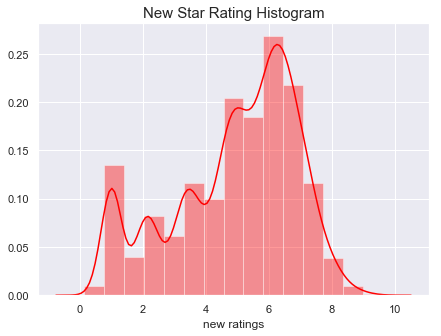

In [193]:
sns.set_style("darkgrid")
plt.figure(figsize=(7,5))
sns.distplot(user_reviews_df['new_rating'],color='red',bins=15)
plt.title('New Star Rating Histogram',fontsize=15)
plt.xlabel('new ratings')
# sns.set(font_scale=1)
plt.savefig("new_start_rating_dist.png");

#### Train-Test Spilt:

there's no good way that's been suggested on the internet to test your models. So, here we will remove a few users with multiple reviews so we can test on them. 

In [29]:
user_reviews_df = open_pickle('Data/reviews_w_new_sentiment')

In [32]:
user_reviews_df['in_NYC'] = user_reviews_df.company_loc.apply(lambda x: in_nyc(x))
user_reviews_df = user_reviews_df[user_reviews_df.in_NYC == 1].drop(['in_NYC'],axis=1).reset_index(drop=True)

In [55]:
tot_users = len(set(user_reviews_df.userUrl))
print(f'There are a total of {tot_users} users, and 20% of that is {int(tot_users*.2)}.')

There are a total of 3831 users, and 20% of that is 766.


In [56]:
user_reviews_df.shape

(13598, 15)

**This is the random list of users we will be selecting and grabbing the usersID and then grabbing all of their rows:**

In [95]:
np.random.seed(3)
users_select = np.random.randint(0,3831,766)

In [96]:
tester = user_reviews_df['userUrl'].drop_duplicates()

In [97]:
new_user_selection = tester.reset_index().reindex(users_select, fill_value=0,copy=True)

In [98]:
def is_sample(url):
    tot_urls = list(set(new_user_selection['userUrl']))
    if url in tot_urls:
        return 1 
    else:
        return 0

In [99]:
tqdm_notebook.pandas(desc="Progress: ")
user_reviews_df['is_sample'] = user_reviews_df.userUrl.progress_apply(lambda url:is_sample(url))
user_reviews_test_df = user_reviews_df[user_reviews_df.is_sample == 1].drop(['is_sample'],axis=1).reset_index(drop=True)
user_reviews_train_df = user_reviews_df[user_reviews_df.is_sample == 0].drop(['is_sample'],axis=1).reset_index(drop=True)

In [100]:
user_reviews_train_df.shape,user_reviews_test_df.shape

((11204, 15), (2394, 15))

In [101]:
len(set(user_reviews_train_df['userUrl'])),len(set(user_reviews_test_df['userUrl']))

(3128, 703)

In [103]:
pickle_file(user_reviews_train_df,'Data/train_data')
pickle_file(user_reviews_test_df,'Data/test_data')

'Pickled object!'

citations:


Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

https://opensourceforu.com/2016/12/analysing-sentiments-nltk/
